# Tabula Muris

- https://tabula-muris.ds.czbiohub.org/
- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE109774

Abstract
Tabula Muris is a compendium of single cell transcriptome data from the model organism Mus musculus, containing nearly 100,000 cells from 20 organs and tissues. The data allow for direct and controlled comparison of gene expression in cell types shared between tissues, such as immune cells from distinct anatomical locations. They also allow for a comparison of two distinct technical approaches:

microfluidic droplet-based 3’-end counting: provides a survey of thousands of cells per organ at relatively low coverage
FACS-based full length transcript analysis: provides higher sensitivity and coverage.
We hope this rich collection of annotated cells will be a useful resource for:

Defining gene expression in previously poorly-characterized cell populations.
Validating findings in future targeted single-cell studies.
Developing of methods for integrating datasets (eg between the FACS and droplet experiments), characterizing batch effects, and quantifying the variation of gene expression in a many cell types between organs and animals.
The peer reviewed article describing the analysis and findings is available on Nature.

[Figshare](https://figshare.com/projects/Tabula_Muris_Transcriptomic_characterization_of_20_organs_and_tissues_from_Mus_musculus_at_single_cell_resolution/27733)に公開されていた。以下の手順で`./data/tabula_muris`にダウンロード、解凍。

```
wget https://ndownloader.figshare.com/files/10700143
unzip 10700143
wget https://ndownloader.figshare.com/files/10700161
mv 10700161 metadata_droplet.csv
wget https://ndownloader.figshare.com/files/13088039
mv 13088039 annotations_droplet.csv

# droplet
wget https://ndownloader.figshare.com/files/10700167
unzip 10700167
wget https://ndownloader.figshare.com/files/13088129
mv 13088129 annotations_facs.csv
wget https://ndownloader.figshare.com/files/10842785
mv 10842785 metadata_FACS.csv
```


In [1]:
import numpy as np
import pandas as pd
# import scanpy.api as sc
import scanpy as sc # versin1.4 以降
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)

sc.settings.autosave = True
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()
# results_file = './scanpy/write/180313merge.mt.h5ad'
# sc.settings.figdir = './scanpy/write/180313merge.mt/graph'
# results_file = './scanpy/write/180514merge.mt.h5ad'
# sc.settings.figdir = './scanpy/write/180514merge.mt/graph'
# sc.settings.cachedir = './scanpy/write/180514merge.mt/cache'

version_date = '20190307'
results_file_facs = 'scdata/{}_tabula_muris_facs.h5ad'.format(version_date)
results_file_droplet = 'scdata/{}_tabula_muris_droplet.h5ad'.format(version_date)
results_file_facs_loom = 'scdata/{}_tabula_muris_facs.loom'.format(version_date)
results_file_droplet_loom = 'scdata/{}_tabula_muris_droplet.loom'.format(version_date)
results_file_facs_loom_cf = 'scdata/{}_tabula_muris_facs.cf.loom'.format(version_date)
results_file_droplet_loom_cf = 'scdata/{}_tabula_muris_droplet.cf.loom'.format(version_date)
sc.settings.figdir = 'scdata/{}_tabula_muris/graph'.format(version_date)
%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'

Running Scanpy 1.4 on 2019-03-09 12:09.
Dependencies: anndata==0.6.18 numpy==1.15.4 scipy==1.1.0 pandas==0.24.1 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## 10X

In [3]:
adata_droplet = sc.read(results_file_droplet_loom, cache=True)
adata_droplet

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


AnnData object with n_obs × n_vars = 55656 × 23433 
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subsetC', 'subsetC_cluster.ids', 'subsetD', 'subsetD_cluster.ids', 'subtissue', 'tissue', 'tissue_tSNE_1', 'tissue_tSNE_2'

## preprocessing

saving figure to file scdata/20190307_tabula_muris/graph/highest_expr_genes.pdf


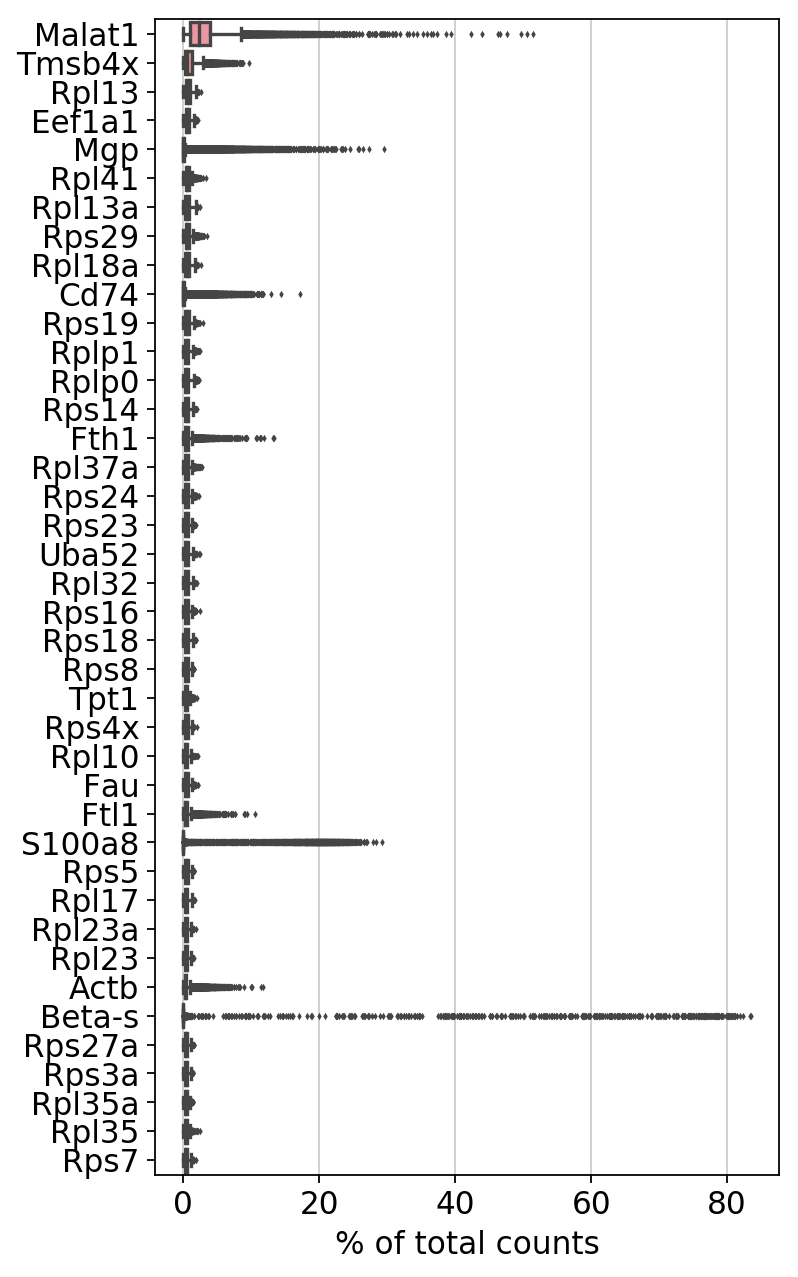

In [4]:
sc.pl.highest_expr_genes(adata_droplet, n_top=40)

In [5]:
# add the total counts per cell as observations-annotation to adata
adata_droplet.obs['n_counts'] = np.sum(adata_droplet.X, axis=1)
sc.pp.filter_cells(adata_droplet, min_genes=0)

... storing 'batch' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'channel' as categorical
... storing 'free_annotation' as categorical
... storing 'mouse.id' as categorical
... storing 'mouse.sex' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical


saving figure to file scdata/20190307_tabula_muris/graph/violinmerge.pdf


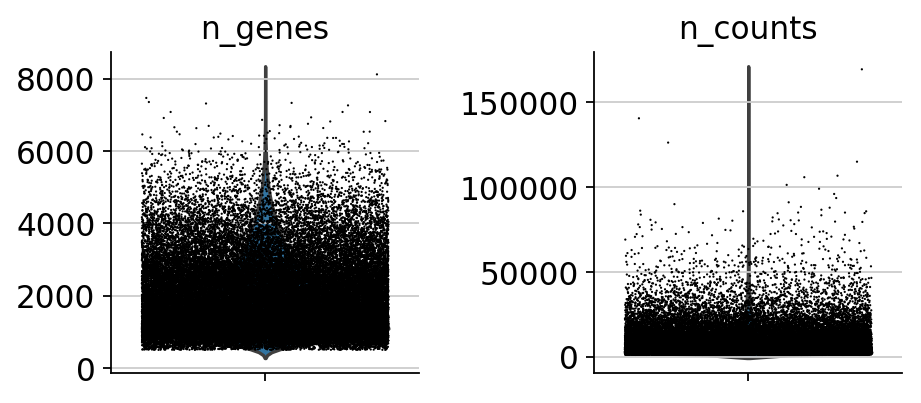

In [6]:
sc.pl.violin(adata_droplet, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True, save='merge')

saving figure to file scdata/20190307_tabula_muris/graph/scatter.pdf


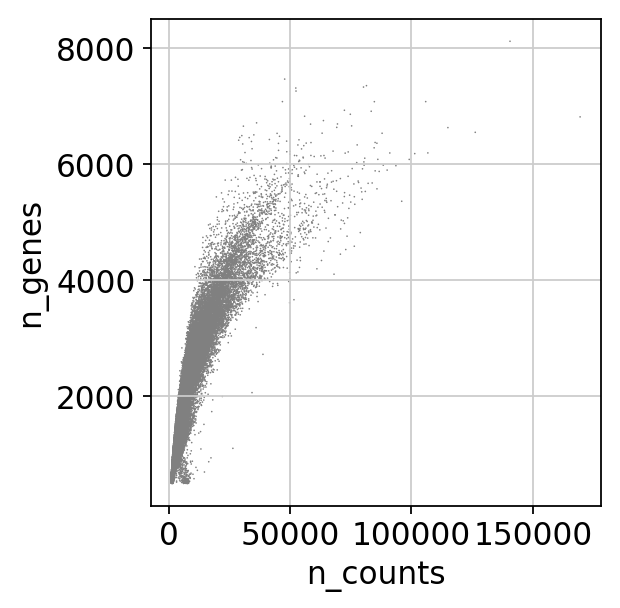

In [7]:
sc.pl.scatter(adata_droplet, x='n_counts', y='n_genes')

In [10]:
adata_droplet.var.tail(10)

Empty DataFrame
Columns: []
Index: [ERCC-00163, ERCC-00164, ERCC-00165, ERCC-00168, ERCC-00170, ERCC-00171, Gfp_transgene, Cre_transgene, Tdtom_transgene, zsGreen_transgene]

In [11]:
ercc_genes = [name for name in adata_droplet.var_names if name.startswith('ERCC-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is only necessary, as X is sparse - it transform to a dense array after summing
# A1 : Return self as a flattened
adata_droplet.obs['percent_ercc'] = np.sum(
    adata_droplet[:, ercc_genes].X, axis=1) / np.sum(adata_droplet.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata_droplet.obs['n_counts'] = np.sum(adata_droplet.X, axis=1)

saving figure to file scdata/20190307_tabula_muris/graph/violinmerge.pdf


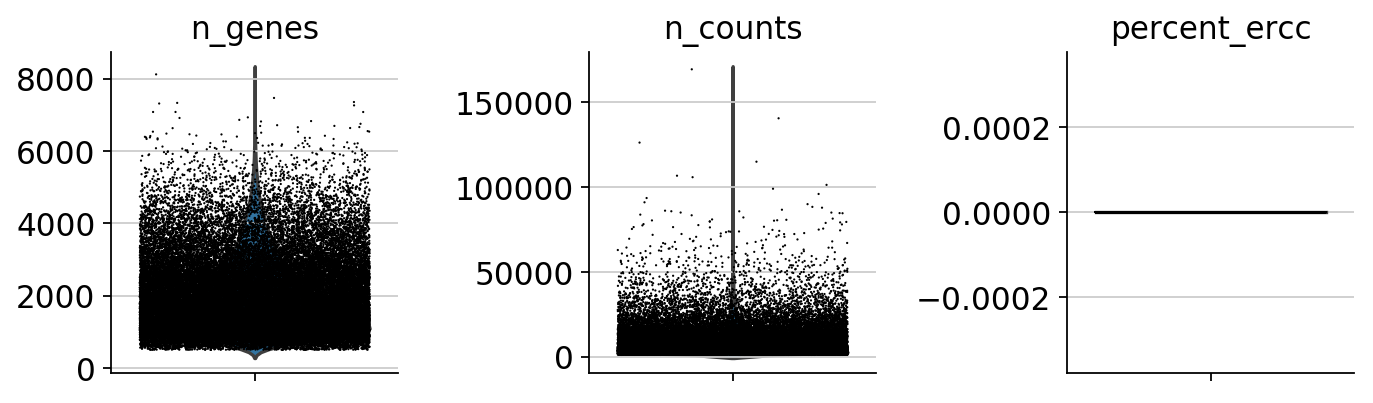

In [12]:
sc.pl.violin(adata_droplet, ['n_genes', 'n_counts', 'percent_ercc'],
             jitter=0.4, multi_panel=True, save='merge')

In [13]:
# # filtering
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=10)
# # ruling out cells with too many genes!
# adata = adata[adata.obs['n_genes'] < 7500, :]

saving figure to file scdata/20190307_tabula_muris/graph/filter_genes_dispersion.pdf


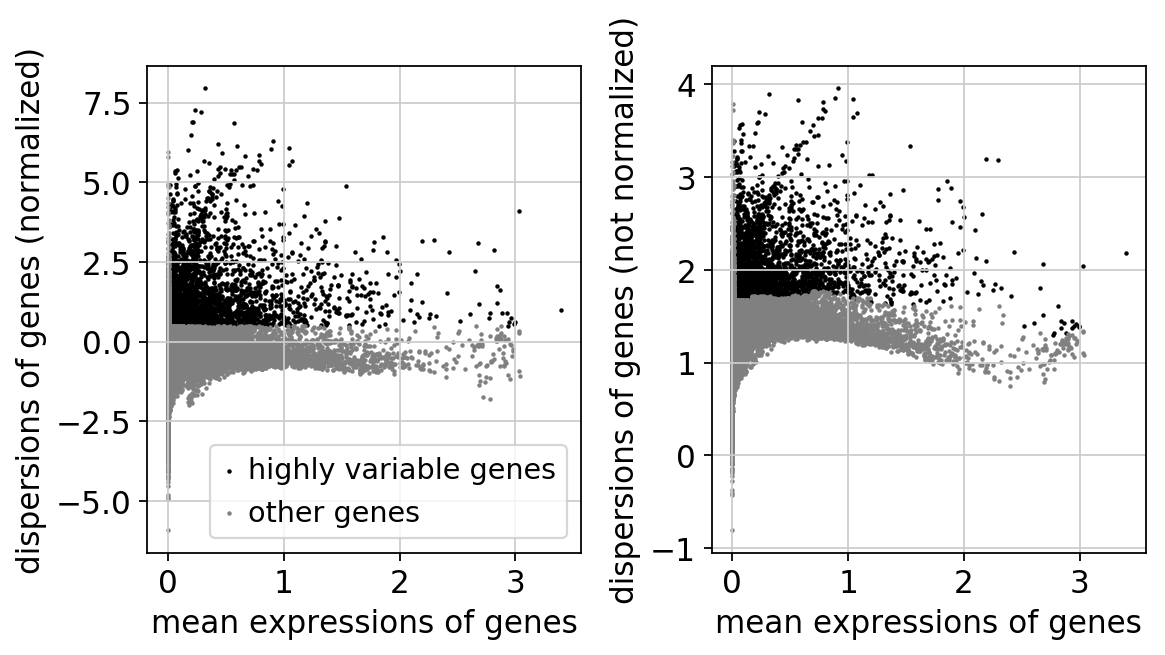

In [14]:
sc.pp.log1p(adata_droplet)
adata_droplet.raw = adata_droplet
sc.pp.normalize_per_cell(adata_droplet, counts_per_cell_after=1e4)

# dispersionを拾うだけで、HVGにしぼりはしない。
# 180521 added
# adata.var_names_make_unique()

filter_result = sc.pp.filter_genes_dispersion(
    adata_droplet.X, min_mean=0.0125, max_mean=3.5, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [20]:
adata_droplet.var['means'] = filter_result.means
adata_droplet.var['dispersions'] = filter_result.dispersions
adata_droplet.var['dispersions_norm'] = filter_result.dispersions_norm
adata_droplet.var['hvg'] = filter_result.gene_subset

adata_droplet = adata_droplet[:, filter_result.gene_subset]

adata_droplet = adata_droplet[:, [name for name in adata_droplet.var_names if not name.startswith('ERCC-')]]

# 今回はいいや
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata_droplet, max_value=10)

adata_droplet.write(results_file_droplet)
# adata.write_csvs('scanpy/180811_csv', skip_data=False)

### Cell Cycle
https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

In [21]:
cell_cycle_genes = [x.strip().capitalize() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_droplet.var_names]

In [24]:
# もう上でしているので不要
# sc.pp.log1p(adata, copy=True)
# sc.pp.scale(adata)

sc.tl.score_genes_cell_cycle(adata_droplet, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:03.98) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:03.64) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


In [26]:
df_obs_cc = adata_droplet.obs[['S_score', 'G2M_score', 'phase']]

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


... storing 'phase' as categorical


saving figure to file scdata/20190307_tabula_muris/graph/pca.pdf


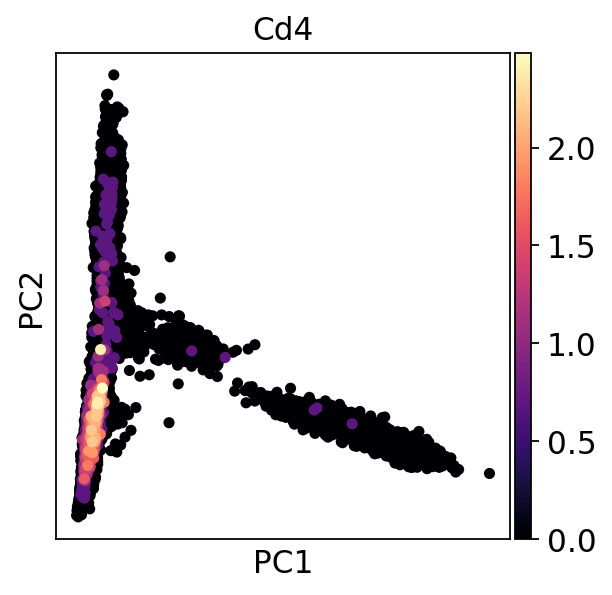

In [27]:
sc.tl.pca(adata_droplet)
# adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat R
sc.pl.pca_scatter(adata_droplet, color='Cd4', size=100, color_map='magma')

saving figure to file scdata/20190307_tabula_muris/graph/pca_variance_ratio.pdf


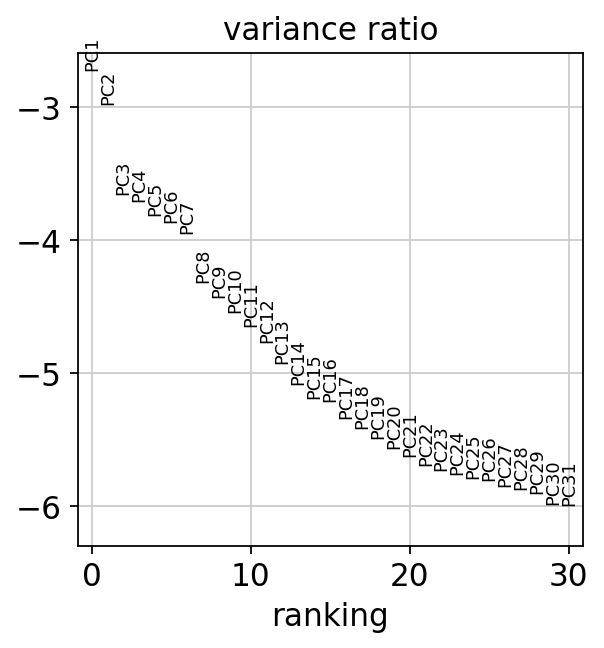

In [29]:
sc.pl.pca_variance_ratio(adata_droplet, log=True)

In [31]:
from scipy.sparse.csgraph import connected_components
# adata = sc.read(results_file)
# sc.tl.umap(adata, metric='correlation')
# np.random.seed(16)
# np.random.seed(46)
# np.random.seed(10)
np.random.seed(0)
# 使用がscanpy==1.0.4でかわってる
# sc.tl.umap(adata, n_components=3, metric='correlation')

# sc.pp.neighbors(adata, metric='correlation')
# sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.pp.neighbors(adata_droplet, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata, n_components=3, random_state=0)
# sc.tl.umap(adata, n_components=3, random_state=100)
sc.tl.umap(adata_droplet, n_components=2, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:08.79) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:51.24) --> added
    'X_umap', UMAP coordinates (adata.obsm)


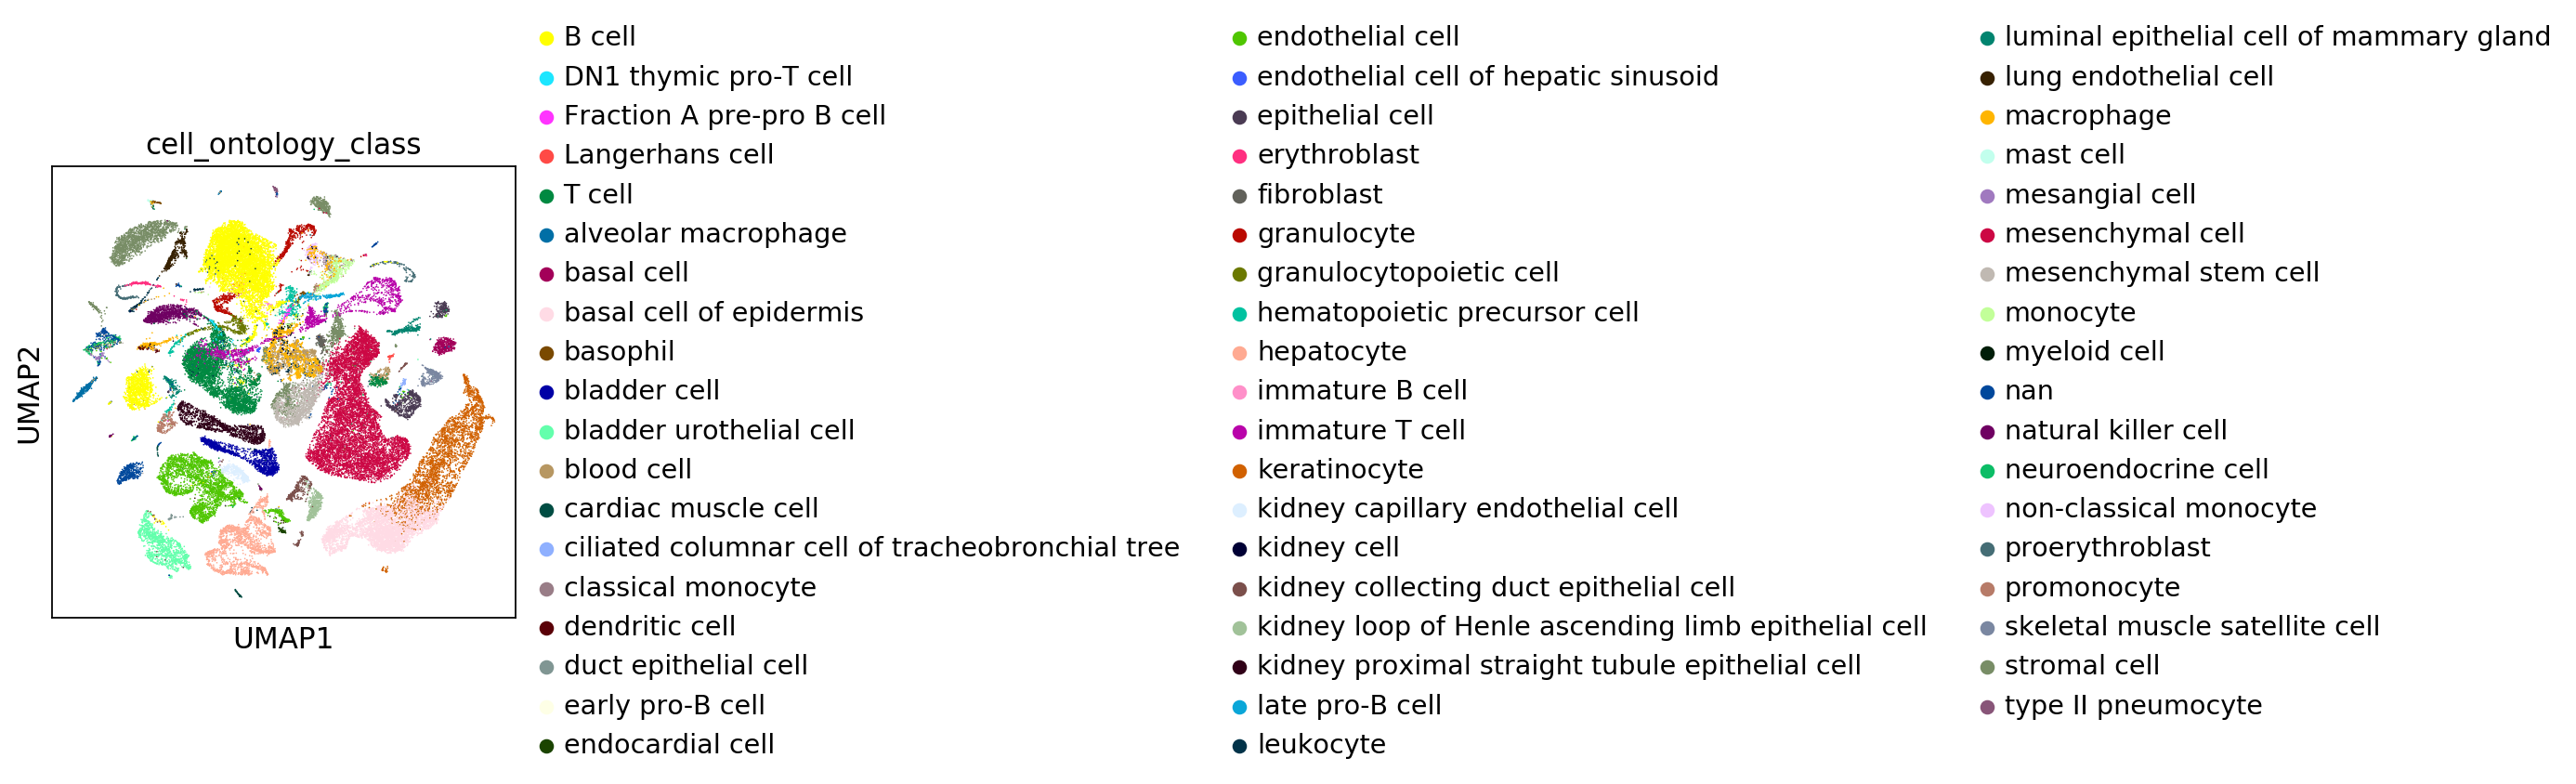

In [38]:
sc.pl.umap(adata_droplet, color=['cell_ontology_class'],
           projection='2d', use_raw=True, save=False)

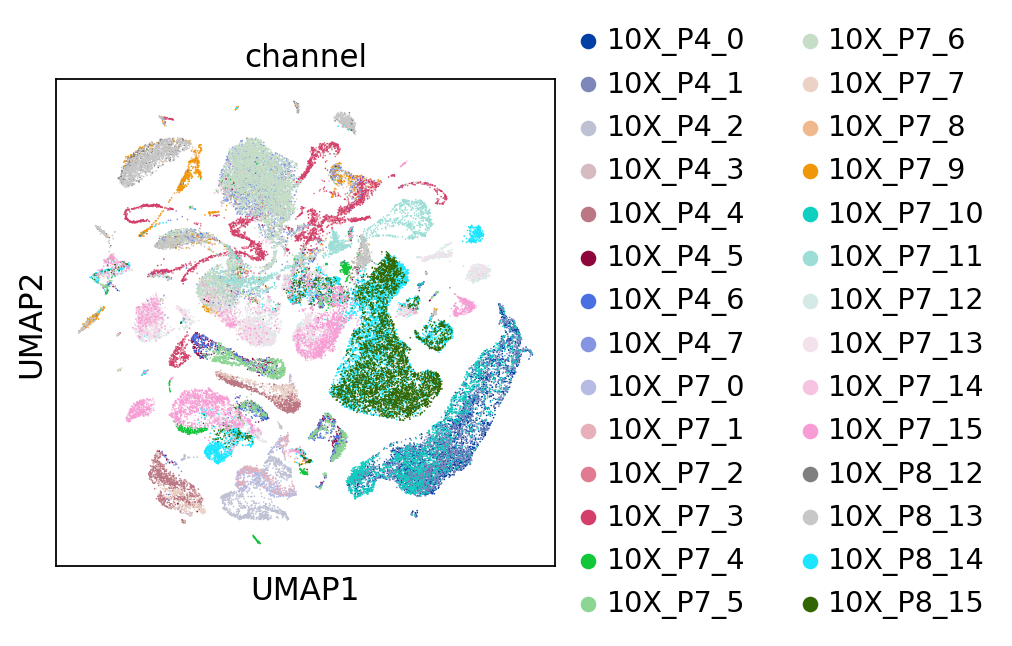

In [40]:
sc.pl.umap(adata_droplet, color=['channel'],
           projection='2d', use_raw=True, save=False)

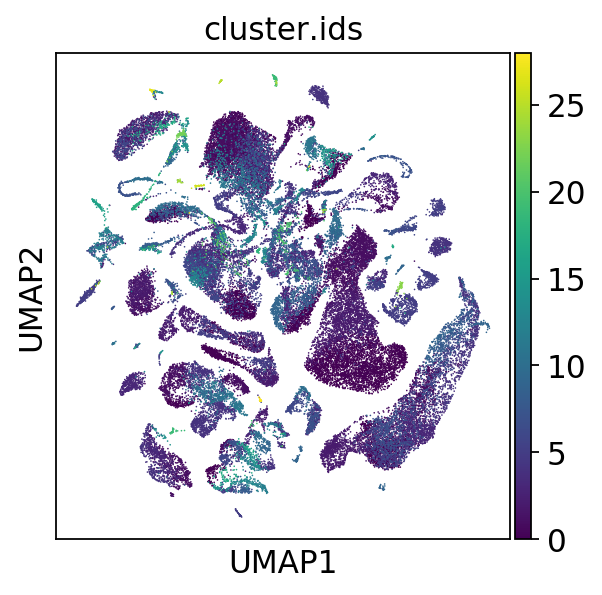

In [42]:
sc.pl.umap(adata_droplet, color=['cluster.ids'],
           projection='2d', use_raw=True, save=False)

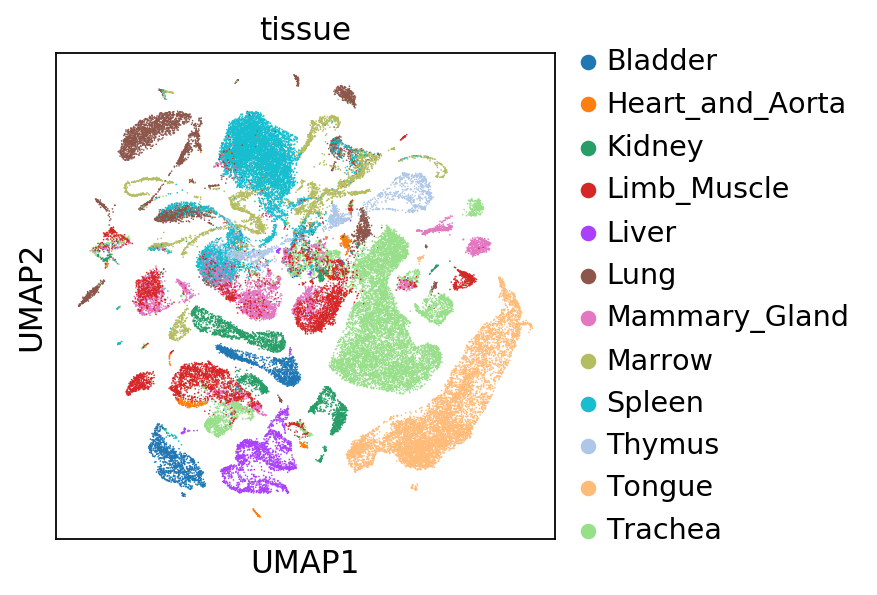

In [43]:
sc.pl.umap(adata_droplet, color=['tissue'],
           projection='2d', use_raw=True, save=False)

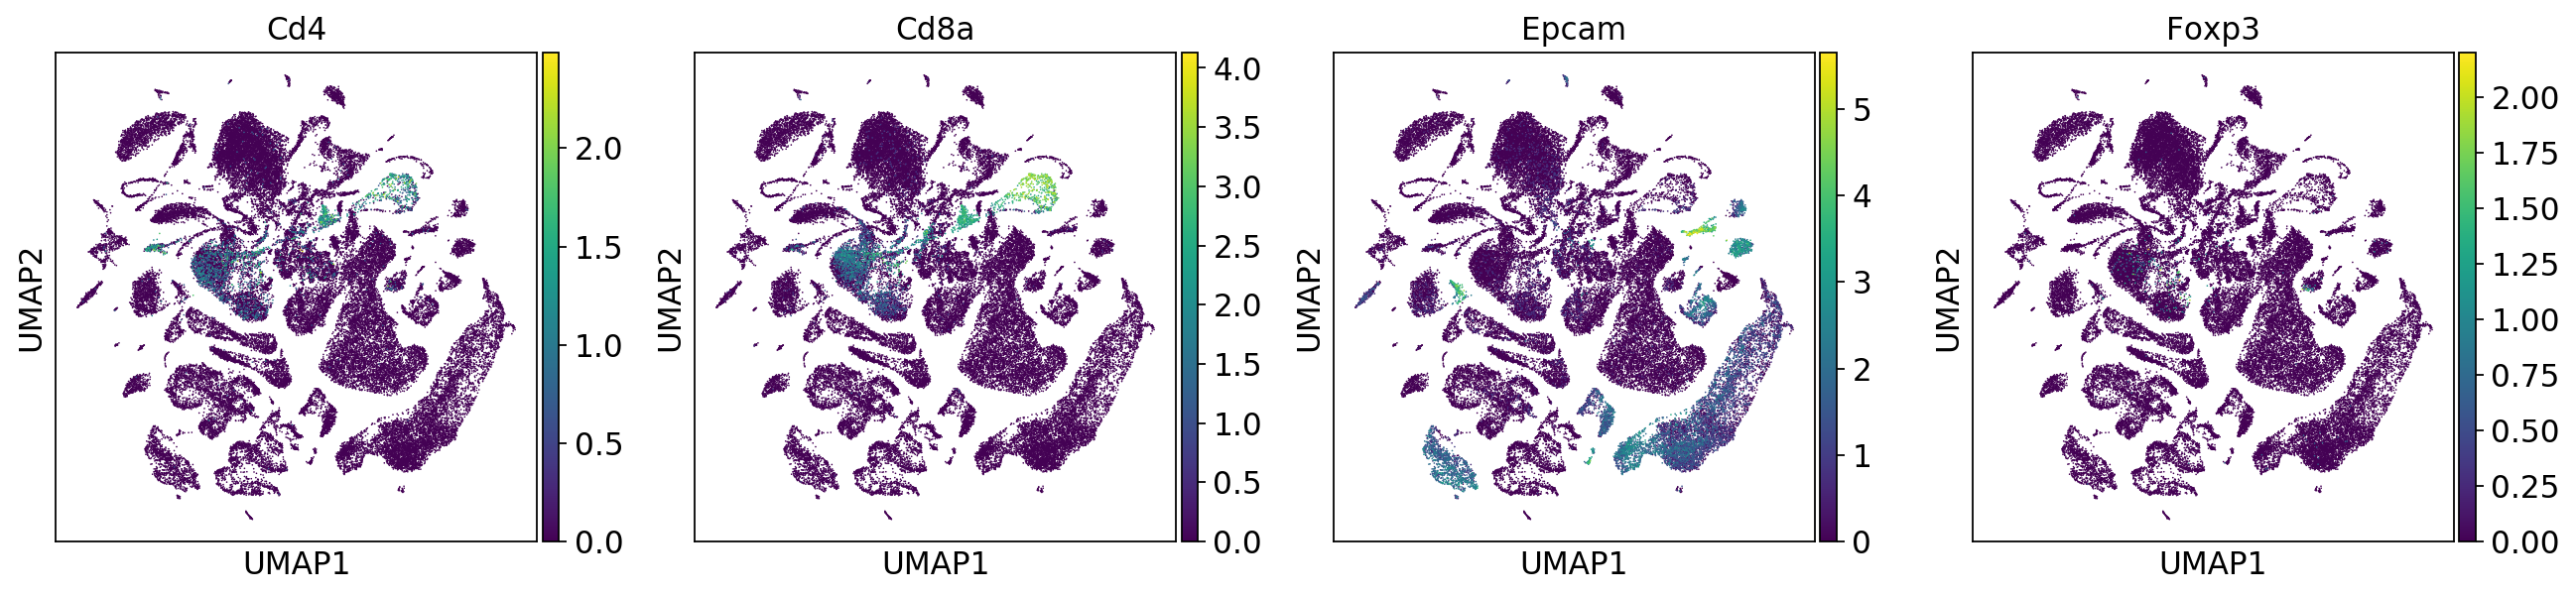

In [48]:
sc.pl.umap(adata_droplet, color=['Cd4', 'Cd8a', 'Epcam'],
           projection='2d', use_raw=True, save=False)

In [51]:
adata_droplet[adata_droplet.obs['cell_ontology_class'] == 'T cell']

View of AnnData object with n_obs × n_vars = 4409 × 3068 
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subsetC', 'subsetC_cluster.ids', 'subsetD', 'subsetD_cluster.ids', 'subtissue', 'tissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'n_counts', 'n_genes', 'percent_ercc', 'S_score', 'G2M_score', 'phase'
    var: 'means', 'dispersions', 'dispersions_norm', 'hvg'
    uns: 'pca', 'neighbors', 'cell_ontology_class_colors', 'channel_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [56]:
adata_droplet_tcell = adata_droplet[adata_droplet.obs['cell_ontology_class'] == 'T cell'].copy()
sc.pp.neighbors(adata_droplet_tcell, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_droplet_tcell, n_components=2, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 40


/home/yyasumizu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:01.95) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:06.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)


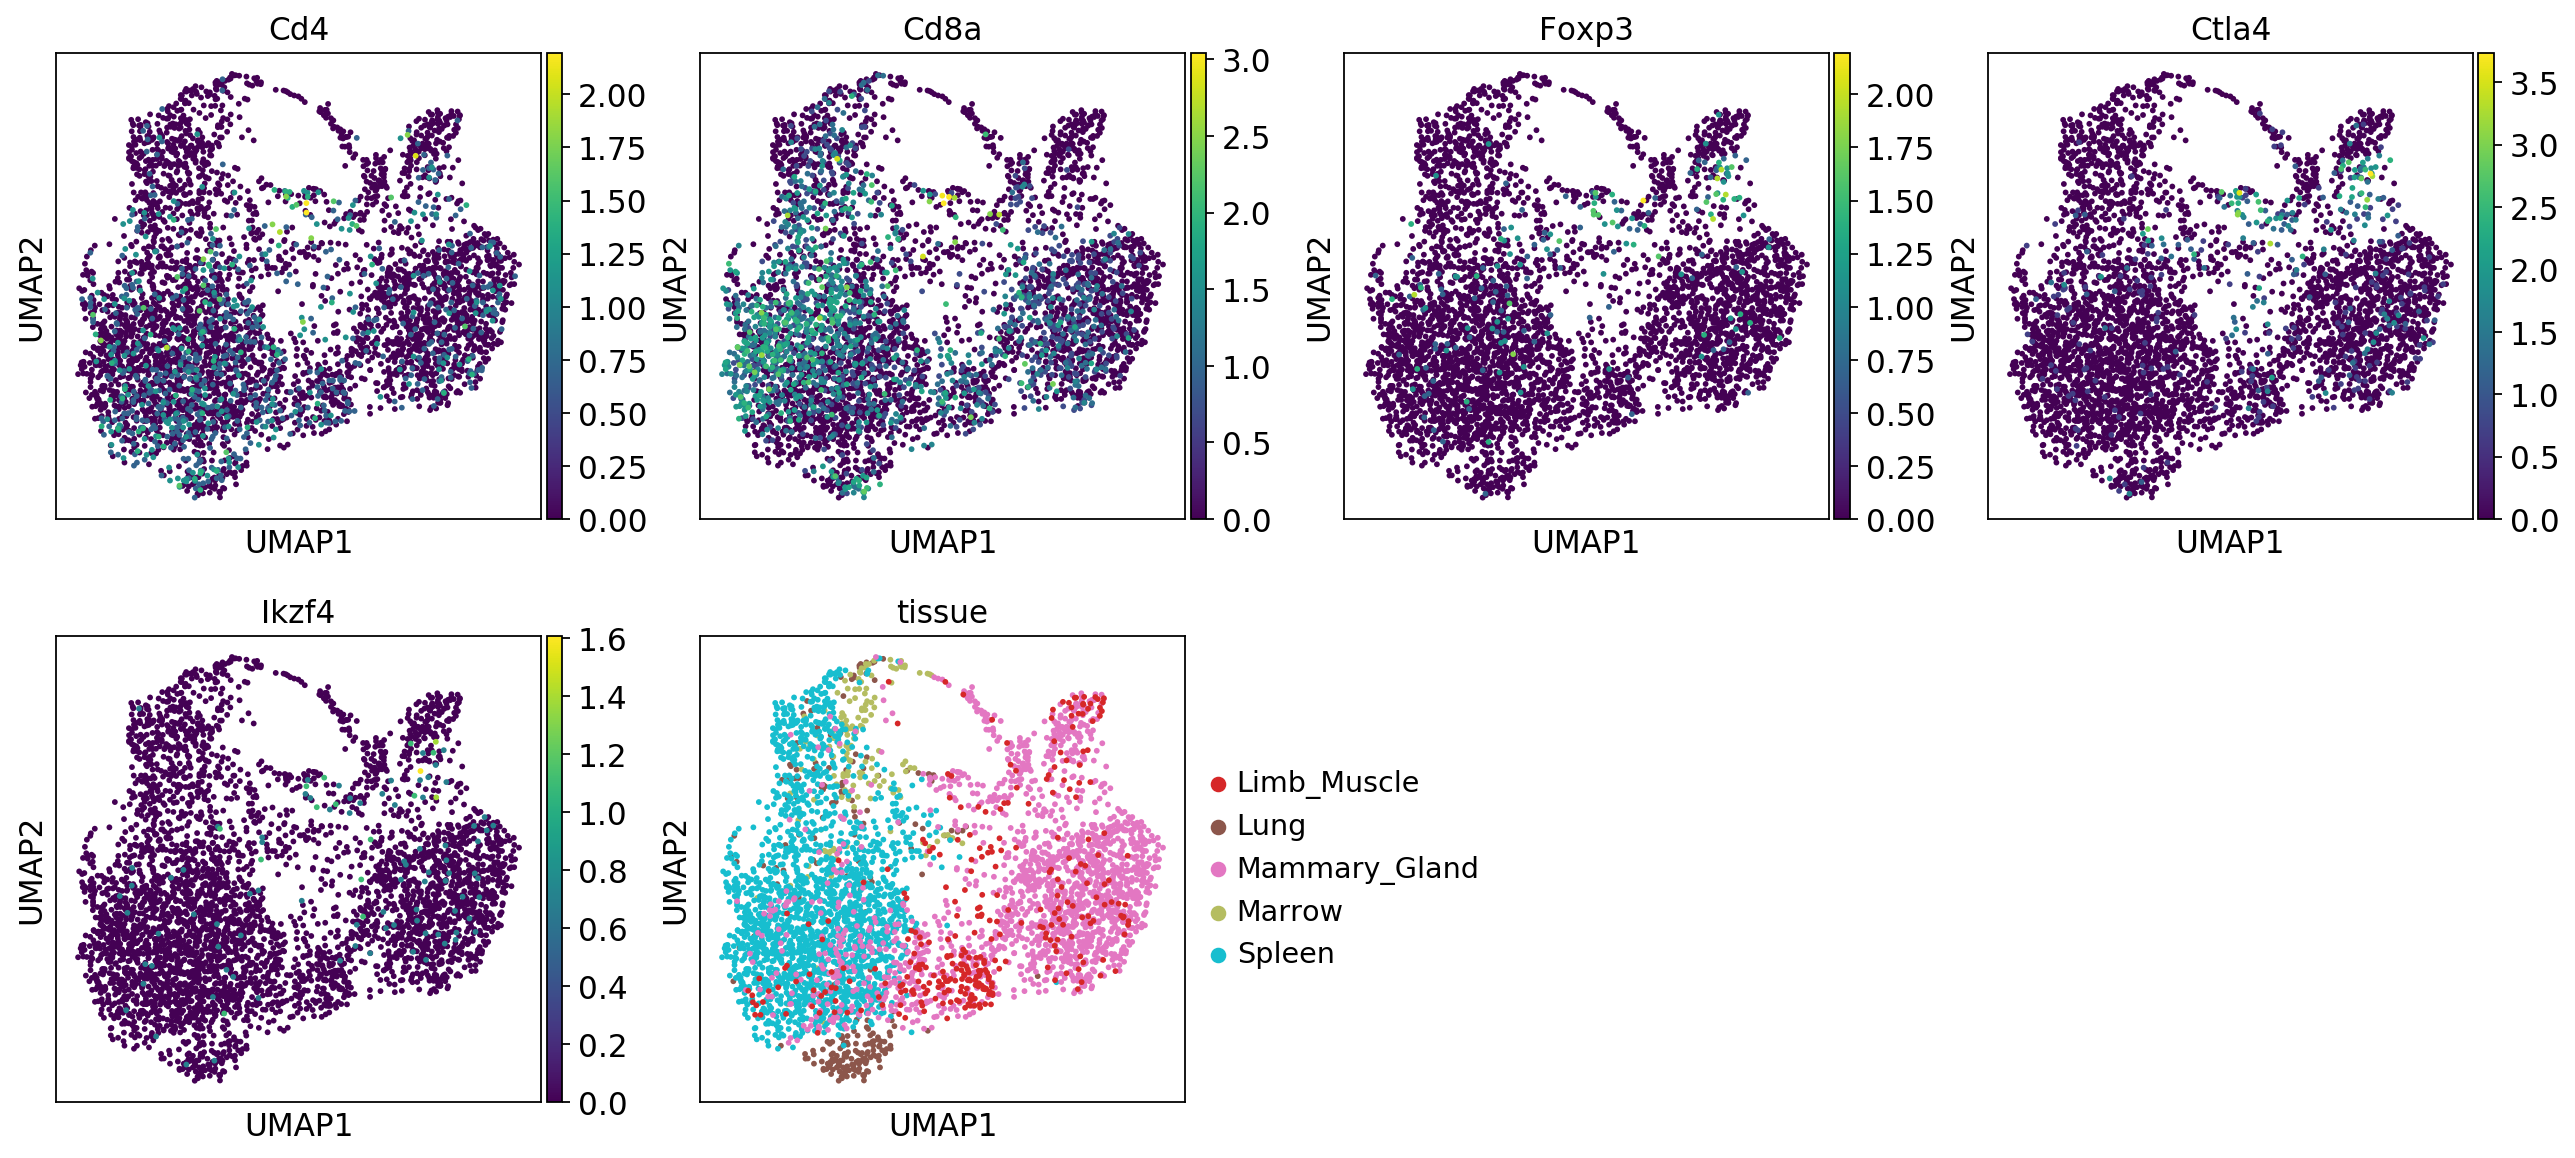

In [58]:
sc.pl.umap(adata_droplet_tcell, color=['Cd4', 'Cd8a', 'Foxp3', 'Ctla4', 'Ikzf4', 'tissue'],
           projection='2d', use_raw=True, save=False)

In [61]:
adata_droplet_thymus = adata_droplet[adata_droplet.obs['tissue'] == 'Thymus'].copy()
sc.pp.neighbors(adata_droplet_thymus, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_droplet_thymus, n_components=2, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.12) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


/home/yyasumizu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:01.91) --> added
    'X_umap', UMAP coordinates (adata.obsm)


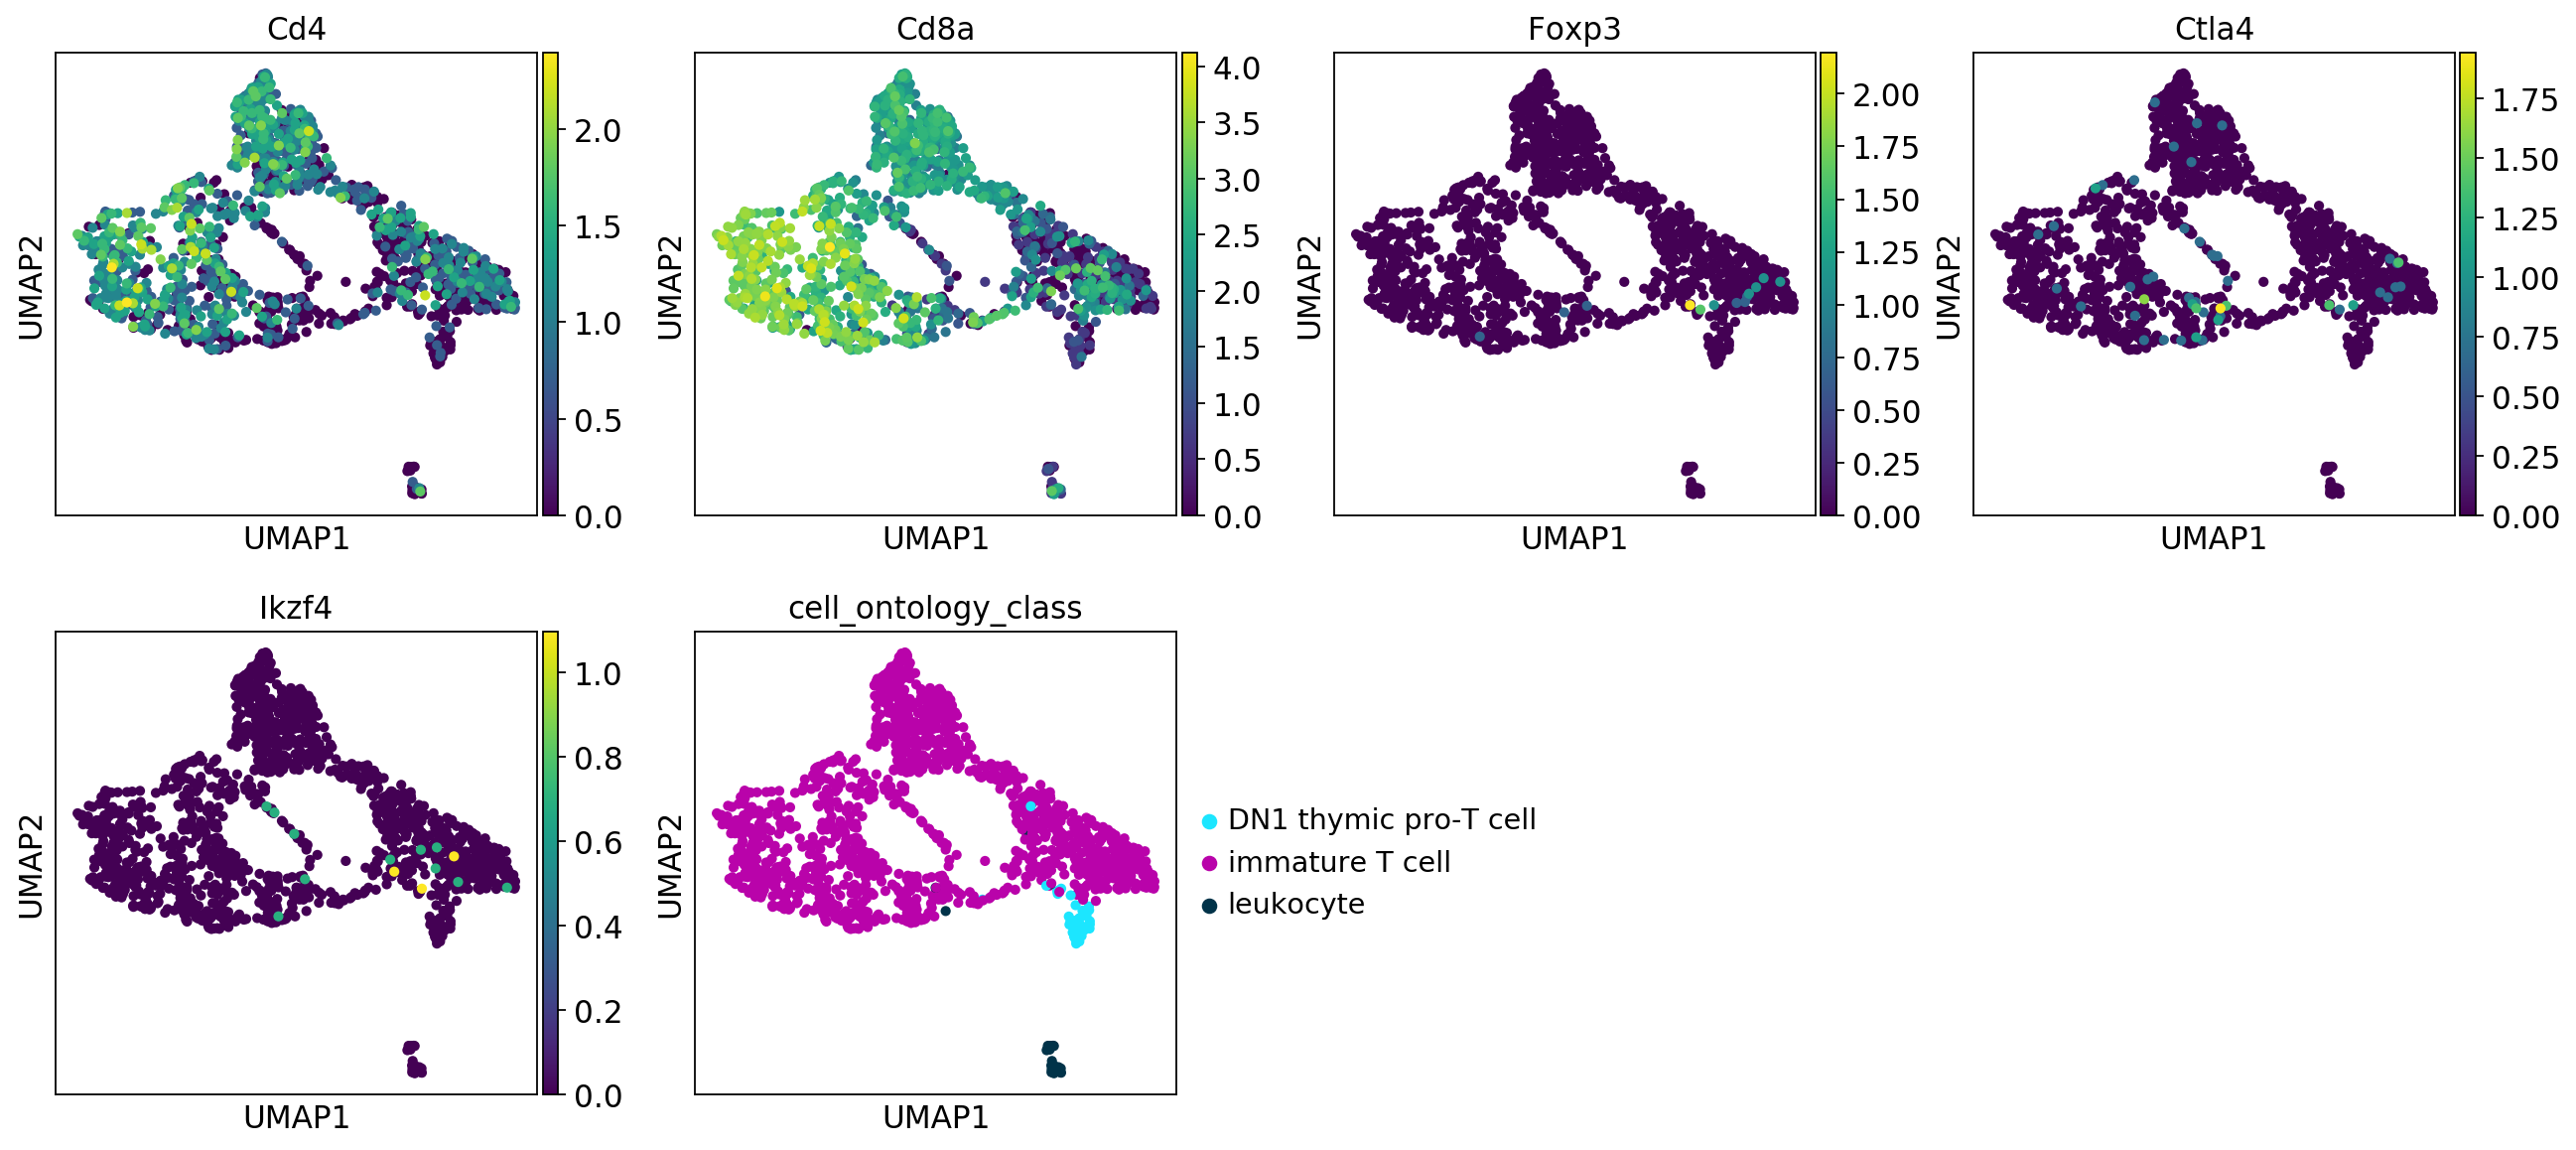

In [63]:
sc.pl.umap(adata_droplet_thymus, color=['Cd4', 'Cd8a', 'Foxp3', 'Ctla4', 'Ikzf4', 'cell_ontology_class'],
           projection='2d', use_raw=True, save=False)

## FACS-SmartSeq2

In [3]:
%%time

# 3min 初回はここを実行。

root_dir_data = 'data/tabula_muris/'

list_csv_facs = [x for x in os.listdir(root_dir_data+'FACS') if x[-3:]=='csv']
list_csv_droplet = [x for x in os.listdir(root_dir_data+'droplet') if x[0]!='.']

for i, f in enumerate(list_csv_facs):
    if i == 0:
        adata_facs = sc.read(root_dir_data+'FACS/'+f).T
#         adata_facs.obs.index = [f.split('-')[1]+'_'+x.split('-')[0] for x in adata_facs.obs.index]
    else:
        _adata = sc.read(root_dir_data+'FACS/'+f).T
#         _adata.obs.index = [f.split('-')[1]+'_'+x.split('-')[0] for x in _adata.obs.index]
        adata_facs = adata_facs.concatenate(_adata)

_adata = 0
# adata_facs.var = adata_facs.var.drop(list(adata_facs.var.columns), axis=1)
# adata_facs.obs.index = [x.split('-')[0] for x in adata_facs.obs.index]

df_anno_facs = pd.read_csv('data/tabula_muris/annotations_facs.csv', index_col=2)
df_anno_facs.head()

adata_facs = adata_facs[df_anno_facs.index,:]

for c in df_anno_facs.columns:
    adata_facs.obs[c] = df_anno_facs.loc[adata_facs.obs.index, c]
   
adata_facs.write_loom(results_file_facs_loom)

# for cellfishing.jl

import loompy

ds = loompy.connect(results_file_facs_loom)
ds.row_attrs['Gene'] = ds.row_attrs['var_names']
ds.col_attrs['CellID'] = ds.col_attrs['obs_names']
loompy.create(results_file_facs_loom_cf, ds[:,:], ds.row_attrs, ds.col_attrs)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading fr

MemoryError: 

In [79]:
df_anno_facs = pd.read_csv('data/tabula_muris/annotations_facs.csv', index_col=2)
df_anno_facs.head()

/home/yyasumizu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Neurog3>0_raw Neurog3>0_scaled      cell_ontology_class  \
cell                                                                            
A1.B000610.3_56_F.1.1           NaN              NaN             bladder cell   
A1.B002764.3_38_F.1.1           NaN              NaN  bladder urothelial cell   
A1.B002771.3_39_F.1.1           NaN              NaN             bladder cell   
A1.D041914.3_8_M.1.1            NaN              NaN             bladder cell   
A1.D042253.3_9_M.1.1            NaN              NaN             bladder cell   

                      cell_ontology_id  cluster.ids  \
cell                                                  
A1.B000610.3_56_F.1.1       CL:1001319            5   
A1.B002764.3_38_F.1.1       CL:1001428            3   
A1.B002771.3_39_F.1.1       CL:1001319            5   
A1.D041914.3_8_M.1.1        CL:1001319            5   
A1.D042253.3_9_M.1.1        CL:1001319            2   

                                       free_annotation mouse.id mouse.sex  \
cell                                                                        
A1.B000610.3_56_F.1.1         Bladder mesenchymal cell   3_56_F         F   
A1.B002764.3_38_F.1.1  Luminal bladder epithelial cell   3_38_F         F   
A1.B002771.3_39_F.1.1         Bladder mesenchymal cell   3_39_F         F   
A1.D041914.3_8_M.1.1          Bladder mesenchymal cell    3_8_M         M   
A1.D042253.3_9_M.1.1          Bladder mesenchymal cell    3_9_M         M   

                      plate.barcode subsetA  ...  subsetC subsetC_cluster.ids  \
cell                                         ...                                
A1.B000610.3_56_F.1.1       B000610     NaN  ...      NaN                 NaN   
A1.B002764.3_38_F.1.1       B002764     NaN  ...      NaN                 NaN   
A1.B002771.3_39_F.1.1       B002771     NaN  ...      NaN                 NaN   
A1.D041914.3_8_M.1.1        D041914     NaN  ...      NaN                 NaN   
A1.D042253.3_9_M.1.1        D042253     NaN  ...      NaN                 NaN   

                       subsetD subsetD_cluster.ids  subsetE  \
cell                                                          
A1.B000610.3_56_F.1.1      NaN                 NaN      NaN   
A1.B002764.3_38_F.1.1      NaN                 NaN      NaN   
A1.B002771.3_39_F.1.1      NaN                 NaN      NaN   
A1.D041914.3_8_M.1.1       NaN                 NaN      NaN   
A1.D042253.3_9_M.1.1       NaN                 NaN      NaN   

                      subsetE_cluster.ids  subtissue   tissue  tissue_tSNE_1  \
cell                                                                           
A1.B000610.3_56_F.1.1                 NaN        NaN  Bladder      -7.182841   
A1.B002764.3_38_F.1.1                 NaN        NaN  Bladder       4.199059   
A1.B002771.3_39_F.1.1                 NaN        NaN  Bladder     -11.995435   
A1.D041914.3_8_M.1.1                  NaN        NaN  Bladder      -6.820022   
A1.D042253.3_9_M.1.1                  NaN        NaN  Bladder     -24.163538   

                      tissue_tSNE_2  
cell                                 
A1.B000610.3_56_F.1.1    -10.895094  
A1.B002764.3_38_F.1.1    -11.050240  
A1.B002771.3_39_F.1.1     -7.325534  
A1.D041914.3_8_M.1.1     -14.174246  
A1.D042253.3_9_M.1.1      -7.499349  

[5 rows x 23 columns]

In [75]:
adata_facs =  sc.read('data/tabula_muris/FACS/Bladder-counts.csv').T

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
